# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

                                      email  interactions
0  0000b6387a0366322d7fbfc6434af145adf7fed1            13
1  001055fc0bb67f71e8fa17002342b256a30254cd             4
2  00148e4911c7e04eeff8def7bbbdaf1c59c2c621             3
3  001a852ecbd6cc12ab77a785efa137b2646505fe             6
4  001fc95b90da5c3cb12c501d201a915e4f093290             2
       interactions
count   5148.000000
mean       8.930847
std       16.802267
min        1.000000
25%        1.000000
50%        3.000000
75%        9.000000
max      364.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3fbf71a668>]], dtype=object)

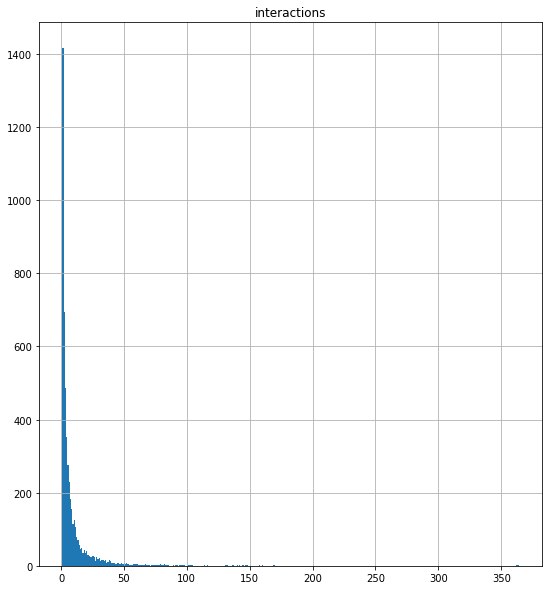

In [3]:
def count_interactions(df, column, interactions):
    '''
    creates a new dataframe that aggregates interactions according to a given category (column)
    INPUTS:
    df - a dataframe containing the required data
    column - a string - the name of the column that the data will be grouped by
    interactions - a string - the name of the column to be counted
    OUTPUTS: 
    new_df - the new dataframe 
    '''
    new_df = df.groupby(column, as_index=False)[interactions].count().rename(columns={interactions: 'interactions'})
    return new_df

#creating a count of interactions per user using count_interactions function
user_interactions = count_interactions(df,'email', 'article_id')
#printing the head and stats description of the new dataframe to check structure and distribution
print(user_interactions.head())
print(user_interactions.describe())
#visualising the distribution of number of interactions
user_interactions.hist(bins=user_interactions['interactions'].max(), figsize=(9,10))

The histogram above demonstrates that the vast majority of users interact with only a very small number of articles.  This drops off sharply and stabilises around a very low frequency the higher the number of interactions gets

In [4]:
#printing median and max values for interactions
median_val = user_interactions['interactions'].median()
max_views_by_user = user_interactions['interactions'].max()
print("50% of individuals interact with {} articles or fewer.".format(median_val))
print("The maximum number of user-article interactions by any 1 user is {}.".format(max_views_by_user))

50% of individuals interact with 3.0 articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [5]:
#duplicate_check returns a descending order list showing where duplicates exist
duplicate_check = df_content['article_id'].value_counts()
duplicate_check.head(10)

221    2
232    2
577    2
398    2
50     2
356    1
355    1
354    1
353    1
345    1
Name: article_id, dtype: int64

In [6]:
#retaining only the first of each instance where there is a duplicate
df_len = len(df_content) #checking initial data frame length
print("There were {} rows initially in the df_content data frame".format(df_len))
df_content.drop_duplicates(subset=['article_id'], inplace=True, keep='first') #drop duplicates
df_difference = df_len - len(df_content) #calculating change in data frame length
print("{} rows have been identified as duplicate articles and removed.".format(df_difference))

There were 1056 rows initially in the df_content data frame
5 rows have been identified as duplicate articles and removed.


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [7]:
unique_articles = df['article_id'].nunique() # The number of unique articles that have at least one interaction
total_articles = len(df_content) # The number of unique articles on the IBM platform
unique_users = len(user_interactions) # The number of unique users
user_article_interactions = len(df) # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [8]:
#creating a count of interactions per article using count_interactions function
article_interactions = count_interactions(df,'article_id', 'title')

def sort_values(df, column):
    '''
    sorting a dataframe in descending order
    INPUTS:
    df - a dataframe
    column - a string representing a column in the dataset that you'd like to sort by
    OUTPUT:
    new_df - the new dataframe
    '''
    
    new_df = df.sort_values(by=[column], ascending=False)
    return new_df

article_interactions = sort_values(article_interactions, 'interactions')

In [9]:
most_viewed_article_id = article_interactions['article_id'].iloc[0].astype(str) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = article_interactions['interactions'].iloc[0] # The most viewed article in the dataset was viewed how many times?

print("Article {} is the most viewed in the dataset with {} views.".format(most_viewed_article_id, max_views))

Article 1429.0 is the most viewed in the dataset with 937 views.


In [10]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [11]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [12]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    top_articles = count_interactions(df,'title', 'user_id') #function for counting interactions
    top_articles = sort_values(top_articles, 'interactions') #function for sorting in descending order
    top_articles = top_articles['title'].tolist()[:n] #list of top n values
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_article_ids - (list) A list of the top 'n' article titles 
    
    '''
    top_article_ids = count_interactions(df,'article_id', 'user_id')
    top_article_ids = sort_values(top_article_ids, 'interactions')
    top_article_ids = top_article_ids['article_id'].tolist()[:n]
    return top_article_ids # Return the top article ids

In [13]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [14]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [15]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    user_item = df[['user_id','article_id']] #retain just id columns
    user_item['interaction']= 1 #assign an indicator of interaction per row
    user_item = user_item.groupby(['user_id','article_id'])['interaction'].max().unstack() #create matrix with users as rows and articles as columns
    user_item = user_item.fillna(0) #fill NaN with 0
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [16]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [17]:
def dot_product(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    OUTPUT:
    dot_products - a dictionary of calculated dot products of given user against other users
    
    Description:
    Computes a measure of similarity between the given user and other users based on article interactions
    '''
    user_articles = user_item.loc[user_id] #isolate article interactions for given user
    dot_products = {} #dictionary for results
    for index, row in user_item.iterrows(): #iterate through each row of users
        dot_products[index] = np.dot(user_articles, row) #calculate dot product of given user against other users
        
    return dot_products

def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Returns an ordered list based on dot product when combined with the prior dot_product function
    
    '''
    # compute similarity of each user to the provided user
    dot_products = dot_product(user_id) #calling dot_product function to build a dictionary
        
    # sort by similarity
    dot_products = sorted(dot_products.items(), key=lambda item: item[1], reverse=True) #sort dictionary by value in descending order
    
    # create list of just the ids
    most_similar_users = [x for (x,y) in dot_products] #retain only first item in each tuple - the user_id

    # remove the own user's id
    most_similar_users.remove(user_id)
       
    # return a list of the users in order from most to least similar
    return most_similar_users    

In [18]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [19]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_names = df[df['article_id'].isin(article_ids)].drop_duplicates(['article_id']) #df of unique rows where id is in list
    article_names = article_names['title'].values.tolist() #transform the title column into a list  
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    articles = user_item.loc[user_id, :] #locate the row for the user
    article_ids = list(map(str, articles[articles>0].index)) #list where interaction occurs
    
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    similarity_list = find_similar_users(user_id) #function to return the ordered list of similar users
    user_own_articles = get_user_articles(user_id)[0] #function to return the users own interactions
    recs = []
    for i in similarity_list: #looping through the list of similar users
        if len(recs)>= m: 
            break #break if there are already more than "m" recs stored
            
        user_articles = get_user_articles(i)[0] #get a list of articles for each user
        for j in user_articles: #looping through articles
            if j not in user_own_articles and j not in recs: #discount if the article is already viewed by the user, or already in the recs list
                recs.append(j) #otherwise append to list
                
    return recs[:m] # return your recommendations for this user_id    

In [20]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'graph-based machine learning',
 'using brunel in ipython/jupyter notebooks',
 'experience iot with coursera',
 'the 3 kinds of context: machine learning and the art of the frame',
 'deep forest: towards an alternative to deep neural networks',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty']

In [21]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [22]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    dot_products = dot_product(user_id) #calling dot_product function to build a dictionary
        
    neighbors_df = pd.DataFrame.from_dict(dot_products, orient='index', columns=['similarity']) #converting dictonary to dataframe
    neighbors_df['neighbor_id'] = neighbors_df.index #ensuring that index (ids) are a callable column
    
    num_interactions = count_interactions(df,'user_id', 'article_id') #function to generate df of total interactions per user
       
    neighbors_df['num_interactions'] = num_interactions['interactions'] #assigning count to a new column
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False) #sort by similary first, then interactions

    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    similarity_list = get_top_sorted_users(user_id)['neighbor_id'].values.tolist() #function to return the ordered list of sorted users
    own_articles = get_user_articles(user_id)[0] #function to return the users own interactions
    article_interactions['article_id']=article_interactions['article_id'].apply(str) #ensure that ordered top articles are strings
    recs = []
    ordered_articles = []
    
    for i in similarity_list: #looping through the list of similar users
        if len(recs)>= m: 
            break #break if there are already more than "m" recs stored
            
        user_articles = get_user_articles(i)[0] #get a list of articles for each user
        for j in article_interactions['article_id']: #iterate through list of top articles
            if j in user_articles:
                ordered_articles.append(j) #append to ordered_articles where the neighbor user has interacted with the article
            
            for k in ordered_articles: #looping through articles
                if k not in own_articles and k not in recs: #discount if the article is already viewed by the user, or already in the recs list
                    recs.append(k) #otherwise append to list
                    
    rec_names = get_article_names(recs[:m]) #call get_article_names function on first 10 recs to return names
    
    return recs[:m], rec_names

In [23]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1271.0', '1053.0', '1396.0', '1296.0', '1324.0', '1186.0', '981.0', '53.0', '495.0', '793.0']

The top 10 recommendations for user 20 are the following article names:
['ibm watson facebook posts for 2015', 'access mysql with python', 'fortune 100 companies', 'times world university ranking analysis', 'top 10 machine learning algorithms for beginners', 'customer demographics and sales', 'super fast string matching in python', 'connect to db2 warehouse on cloud and db2 using scala', '10 powerful features on watson data platform, no coding necessary', 'introducing streams designer']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [24]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1)['neighbor_id'].tolist()[1] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131)['neighbor_id'].tolist()[10] # Find the 10th most similar user to user 131

In [25]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**_Which functions would I use to make recommendations to a new user?_**

Given that with a new user there isn't a relationship to existing users that can be implied, my initial approach to recommending content would be to avoid functions that rely on user_ids as input, or that map user-article interactions as a boolean true/false.  Instead functions that generate simple hierarchies would be better.

Going through these exercises I have found this to generally be a useful approach to aggregating the data, which is why I ended up creating my own function `count_interactions` to avoid repetition of this process.

`count_interactions` can be found embedded in some other functions that, combined, are even more relevant to this problem of a new user:

- `sort_values` to create and ordered list of the most popular articles
- `get_top_articles` or `get_top_ids` to specify a number of recommendations from a sorted list (where `sort_values` makes another appearance) 

Alteratively `count_interactions` combined with `sort_values` could also be used to generate an ordered count of interactions by user.  Those most-engaged users could then be used as a guide for the **_right_** content to keep people on the platform, and their ids could be fed into `get_user_articles`, or perhaps a function modified to accept something akin to **_top 5 users_** and recommend articles they interact with most consistently.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [26]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
top_recs = get_top_article_ids(10) #top 10 articles
new_user_recs = []
for rec in top_recs:
    new_user_recs.append(str(rec)) #adding all recs to list as strings

#recommending top 10 articles interacted with by all users, given that there is no basis for comparison to other users

In [27]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [28]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [29]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [30]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)

In [31]:
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

**_Why this implementation is different from the lesson..._**

In the lesson we studied **FunkSVD**, which is a much more robust SVD model that works even in instances where we have NaN values in our matrix.  

The data in this notebook, however, is based around a binary check - and an interaction will always have either occurred, or not occurred, so we have no NaN values.  

This means that the numpy SVD model is sufficient for use with our data.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

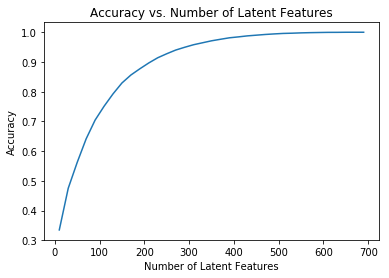

In [32]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [33]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train) #call create_user_item_matrix fuction on train dataframe
    user_item_test = create_user_item_matrix(df_test) #call create_user_item_matrix fuction on test dataframe
    
    test_idx = user_item_test.index #ids in test data
    test_arts = user_item_test.columns #articles in test data
    
    train_idx = user_item_train.index #ids in train data
    train_arts = user_item_train.columns #articles in train data
    
    overlap_idx = train_idx.isin(test_idx) #true/false where ids in both test and train lists
    overlap_arts = train_arts.isin(test_arts) #true/false where articles in both test and train lists
    
    true_ids = user_item_train.index[overlap_idx] #ids where overlap is true
    user_item_test = user_item_train.loc[true_ids] #re-assign the test dataframe for the overlap ids only
    return user_item_train, user_item_test, test_idx, test_arts, overlap_idx, overlap_arts

user_item_train, user_item_test, test_idx, test_arts, overlap_idx, overlap_arts = create_test_and_train_user_item(df_train, df_test)

In [34]:
#identify users in test that are also in train

print("There are {} total users in the test set".format(len(test_idx))) #length of test id list
print("There are {} total articles in the test set".format(len(test_arts))) #length of test article list

print("There are {} users in both the test and train sets".format(sum(overlap_idx))) #check sum of true in overlap for ids
print("There are {} articles in both the test and train sets".format(sum(overlap_arts))) #check sum of true in overlap for articles

There are 682 total users in the test set
There are 574 total articles in the test set
There are 20 users in both the test and train sets
There are 574 articles in both the test and train sets


In [35]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [36]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [37]:
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

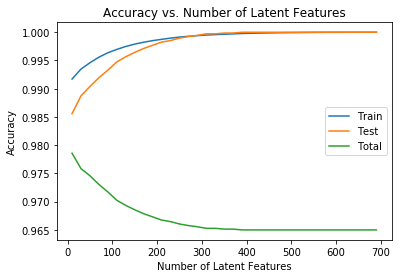

In [38]:
u_test = u_train[overlap_idx, :] #SVD u values for rows in both test and train data
vt_test = vt_train[:, overlap_arts] #SVD vt values for columns in both test and train data

num_latent_feats = np.arange(10,700+10,20)

total_error = []
train_error_sum = []
test_error_sum = []

for k in num_latent_feats:
    # restructure with k latent features for train and overlap(test) data as defined above
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:,:k], vt_test[:k,:]
    
    # take dot products
    user_item_train_preds = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction to actual value
    train_diff = np.subtract(user_item_train, user_item_train_preds)
    test_diff = np.subtract(user_item_test.loc[user_item_train.iloc[overlap_idx].index,
                                               user_item_train.iloc[:,overlap_arts].columns],
                            user_item_test_preds)
    
    # total errors and keep track of them
    train_error = np.sum(np.sum(np.abs(train_diff)))
    test_error = np.sum(np.sum(np.abs(test_diff)))
    
    # append errors to lists to enable plotting    
    train_error_sum.append(train_error)
    test_error_sum.append(test_error)
    total_error.append(1-
    ((np.sum(user_item_test_preds)+np.sum(np.sum(user_item_test)))/(user_item_test.shape[0]*user_item_test.shape[1])))
    
max_err_train = user_item_train.shape[0]*user_item_train.shape[1] # full dimensions of train matrix as max error
max_err_test = user_item_test.shape[0]*user_item_test.shape[1] # full dimensions of test matrix as max error

#plotting test, train and total values for k
plt.plot(num_latent_feats, 1 - np.array(train_error_sum)/max_err_train);
plt.plot(num_latent_feats, 1 - np.array(test_error_sum)/max_err_test);
plt.plot(num_latent_feats, total_error);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend(['Train','Test','Total']);

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**_My comments on SVD results..._**

Plotting the accuracy over k latent features of both the train and test data suggests that a good number of latent features to keep could be around 300.  Anything exceeding that doesn't seem to significantly improve accuracy.  That said, there are only 20 users exclusively in the test sample, so accuracy might not be the best guide of the model's performance, given the sample size.

Before releasing my experiment into the wild, I might want to repeat the SVD process with a new test/train split to see if the results are consistent.  If they are, I'd look to isolate the 300 latent features with the highest relationship to the the user/article and I would remultiply my svd matrix to generate better recommendations.

In terms of A/B testing, I would probably also like to get a sense of frequency of interaction with articles on the platform in terms of time, rather than purely numbers.  If our most engaged visitors are on the site every day, but others only log in once a week, then that could impact the length I'd wish to run my experiment.

If my experimentation period were a couple of weeks then IP address would probably be a stable enough way to separate user groups.  Using devices would be better if the recommendation engine was being optimised for smart phone (for example), but otherwise would lead to us tracking users multiple times.  Needing a user_ID before separating user groups would exclude new users, and we do also want to see how they find our recommendations.

Success could be an increase in article interactions, or monitoring to see how far into a recommended article a user gets before closing it.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])